PROYECTO DE DESARROLLO DE SOLUCIONES

INTEGRANTES:# 📌 Proyecto de Desarrollo de Soluciones

## 👥 Integrantes del Equipo

- **Jean Marteen Munevar**  
- **Carlos Chaparro**  
- **Erika Cárdenas**  
- **Gabriela Munevar**  


IMPORTAR LIBRERIAS PARA EL EDA

In [80]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, DetectorFactory
import textstat
from wordcloud import WordCloud

## 📂 Carga y preparación de datos

El siguiente bloque de código realiza las operaciones iniciales necesarias para trabajar con el dataset procesado:

```python
# --- Rutas relativas desde el notebook ---
DATA_PATH = "../data/processed/dataset_clean_v1.csv"
OUTDIR = "../docs/report_assets"



In [64]:

# --- Rutas relativas desde el notebook ---
DATA_PATH = "../data/processed/dataset_clean_v1.csv"
OUTDIR = "../docs/report_assets"

# Crear carpeta de salidas si no existe
os.makedirs(OUTDIR, exist_ok=True)

# Cargar dataset
df = pd.read_csv(DATA_PATH, encoding="utf-8", low_memory=False)
print("Shape:", df.shape)
df.head()



Shape: (182753, 9)


,texto_original,resumen,source,doc_id,split,label,source_dataset,source_bucket,has_pair
0,NIS-LL: a subscale (of 37-item NIS questionnai...,NaN,test,NCT00925002.txt#L1,test,NaN,clinicaltrials,test,False
1,Norfolk QOL-DN: 35-item participant-rated ques...,NaN,test,NCT00925002.txt#L2,test,NaN,clinicaltrials,test,False
2,Karnofsky performance scale was used for ratin...,NaN,test,NCT00925002.txt#L3,test,NaN,clinicaltrials,test,False
3,Safety And Efficacy Evaluation Of Fx-1006A In ...,NaN,test,NCT00925002.txt#L4,test,NaN,clinicaltrials,test,False
4,Criteria for clinically significant changes: S...,NaN,test,NCT00925002.txt#L5,test,NaN,clinicaltrials,test,False


In [65]:
df.columns


Index(['texto_original', 'resumen', 'source', 'doc_id', 'split', 'label',
       'source_dataset', 'source_bucket', 'has_pair'],
      dtype='object')

# 📊 Exploración de Datos (EDA)

## Estructura inicial del dataset
- El dataset consolidado contiene **182,753 registros** y **9 columnas**:
  - `texto_original`, `resumen`, `source`, `doc_id`, `split`, `label`,
    `source_dataset`, `source_bucket`, `has_pair`.



In [66]:
df["label"].value_counts()

label
non_pls    80737
pls        48997
Name: count, dtype: int64

In [67]:
df["resumen"] = df["resumen"].fillna("").astype(str)

print("Tipo de dato:", df["resumen"].dtype)
print("Ejemplo de valores:", df["resumen"].head())

print("% con resumen:", (df["resumen"].str.len() > 0).mean() * 100)



Tipo de dato: object
Ejemplo de valores: 0    
1    
2    
3    
4    
Name: resumen, dtype: object
% con resumen: 26.810503794739347



**Interpretación:** buena parte de las filas provienen de ClinicalTrials.gov en formato técnico, sin resumen asociado.


## Distribución por etiqueta (`label`)
- `non_pls`: **80,737** ejemplos  
- `pls`: **48,997** ejemplos  

**Interpretación:** existe un desbalance claro: predominan los textos **sin lenguaje sencillo (non_pls)** frente a los que sí son PLS. Esto implica que cualquier modelo de clasificación podría sesgarse hacia la clase mayoritaria y será necesario balancear los datos.


## Presencia de resúmenes
- Tipo de la columna `resumen`: **object**  
- Porcentaje con resumen válido: **26.81%**

**Interpretación:** apenas 1 de cada 4 registros contiene un resumen en lenguaje sencillo. La mayoría de ejemplos corresponden a textos sin resumen directo, lo que limita la cantidad de pares supervisados disponibles para entrenar modelos de resumen automático.


## Implicaciones para el proyecto
1. **Volumen suficiente:** con más de 180k registros, el corpus es adecuado para experimentación en NLP.  
2. **Desbalance de clases:** predominan los textos *non_pls* (~62% del total), lo que puede afectar tareas de clasificación.  
3. **Cobertura baja de resúmenes:** solo ~27% del dataset tiene PLS. Esto plantea la necesidad de:
 - Métodos de aprendizaje semi-supervisado.  
 - Uso de LLMs para generación de PLS cuando no hay pares.  
4. **Próximos pasos:** analizar la longitud y legibilidad de los textos, identificar outliers y preparar subconjuntos *train/test* equilibrados.


In [68]:
# Normalizar columnas principales
for col in ["texto_original", "resumen"]:
    if col not in df.columns:
        df[col] = ""
    df[col] = df[col].fillna("").astype(str)

# Longitudes en caracteres y palabras
df["len_src"] = df["texto_original"].str.len()
df["len_pls"] = df["resumen"].str.len()

df["wc_src"] = df["texto_original"].str.split().apply(len)
df["wc_pls"] = df["resumen"].str.split().apply(len)

# Ratios de reducción (solo si hay resumen)
df["len_ratio_pls_src"] = np.where(df["len_src"] > 0, df["len_pls"] / df["len_src"], np.nan)
df["wc_ratio_pls_src"]  = np.where(df["wc_src"] > 0, df["wc_pls"] / df["wc_src"], np.nan)

df.head()


,texto_original,resumen,source,doc_id,split,label,source_dataset,source_bucket,has_pair,len_src,len_pls,wc_src,wc_pls,len_ratio_pls_src,wc_ratio_pls_src
0,NIS-LL: a subscale (of 37-item NIS questionnai...,,test,NCT00925002.txt#L1,test,NaN,clinicaltrials,test,False,895,0,129,0,0.0,0.0
1,Norfolk QOL-DN: 35-item participant-rated ques...,,test,NCT00925002.txt#L2,test,NaN,clinicaltrials,test,False,671,0,102,0,0.0,0.0
2,Karnofsky performance scale was used for ratin...,,test,NCT00925002.txt#L3,test,NaN,clinicaltrials,test,False,992,0,138,0,0.0,0.0
3,Safety And Efficacy Evaluation Of Fx-1006A In ...,,test,NCT00925002.txt#L4,test,NaN,clinicaltrials,test,False,85,0,11,0,0.0,0.0
4,Criteria for clinically significant changes: S...,,test,NCT00925002.txt#L5,test,NaN,clinicaltrials,test,False,672,0,112,0,0.0,0.0


In [69]:
# Proporción de filas sin resumen
pct_missing = (df["len_pls"] == 0).mean() * 100
print(f"Porcentaje de ejemplos sin resumen: {pct_missing:.2f}%")

# Revisar duplicados
dup_count = df.duplicated(subset=["texto_original","resumen"]).sum()
print(f"Número de duplicados exactos (texto+resumen): {dup_count}")

# Valores vacíos en general
df.isna().sum()


Porcentaje de ejemplos sin resumen: 73.19%
Número de duplicados exactos (texto+resumen): 0


texto_original           0
resumen                  0
source                   0
doc_id                   0
split                    0
label                53019
source_dataset           0
source_bucket            0
has_pair                 0
len_src                  0
len_pls                  0
wc_src                   0
wc_pls                   0
len_ratio_pls_src    48997
wc_ratio_pls_src     48997
dtype: int64

1. **Alta proporción de textos sin resumen:** representa un desafío para modelos de generación supervisada, ya que solo un 26–27% de las instancias tienen pares texto–PLS disponibles.  
2. **Ausencia de duplicados:** la limpieza inicial garantiza un corpus diverso.  
3. **Etiquetas incompletas:** se deberá revisar el mapeo de `label` desde las rutas para asignar categorías a los ~53k registros sin clasificar.  
4. **Ratios de reducción nulos:** estos valores no se calculan en ausencia de PLS, por lo que son esperables y no constituyen un error de calidad.

**Conclusión:** El dataset es amplio y limpio, pero altamente desbalanceado hacia textos sin PLS. Para los siguientes pasos será necesario diseñar estrategias que combinen clasificación (PLS vs. non-PLS) y generación de resúmenes en los casos donde faltan.

In [70]:
def describe_series(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return pd.Series({
        "count": s.count(),
        "mean": s.mean(),
        "std": s.std(),
        "min": s.min(),
        "25%": s.quantile(0.25),
        "50%": s.median(),
        "75%": s.quantile(0.75),
        "max": s.max()
    })

stats_len_src = describe_series(df["len_src"])
stats_len_pls = describe_series(df.loc[df["len_pls"] > 0, "len_pls"])
stats_wc_src  = describe_series(df["wc_src"])
stats_wc_pls  = describe_series(df.loc[df["wc_pls"] > 0, "wc_pls"])

summary_stats = pd.DataFrame({
    "len_src": stats_len_src,
    "len_pls": stats_len_pls,
    "wc_src": stats_wc_src,
    "wc_pls": stats_wc_pls
})

summary_stats.to_csv(os.path.join(OUTDIR, "length_stats.csv"), encoding="utf-8")
summary_stats



,len_src,len_pls,wc_src,wc_pls
count,182753.000000,48997.000000,182753.000000,48997.000000
mean,209.254672,338.746454,31.629401,52.614691
std,290.009165,315.118099,44.231104,48.744290
min,0.000000,30.000000,0.000000,2.000000
25%,0.000000,107.000000,0.000000,16.000000
50%,84.000000,252.000000,14.000000,39.000000
75%,303.000000,469.000000,44.000000,73.000000
max,4703.000000,4792.000000,774.000000,741.000000


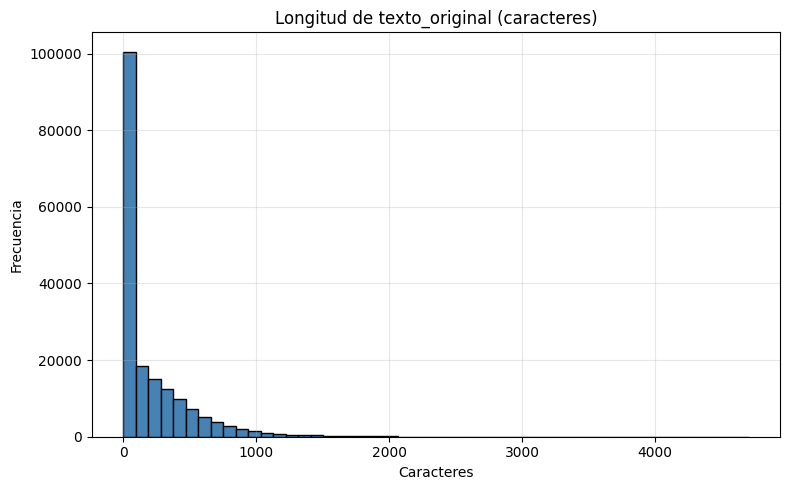

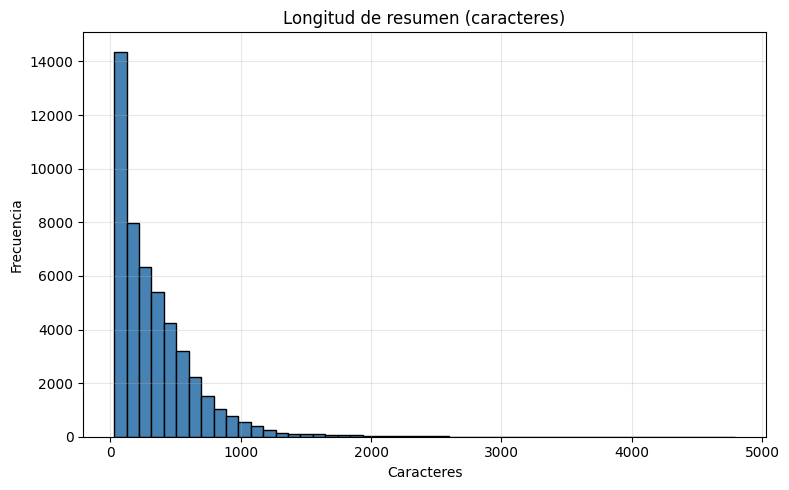

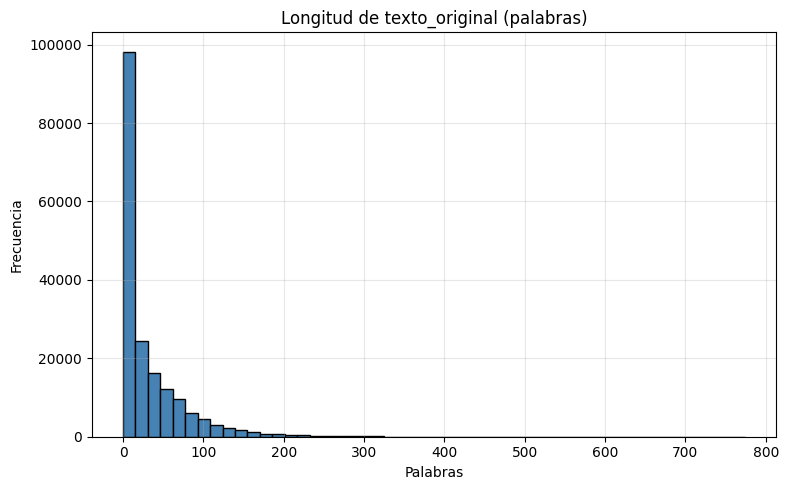

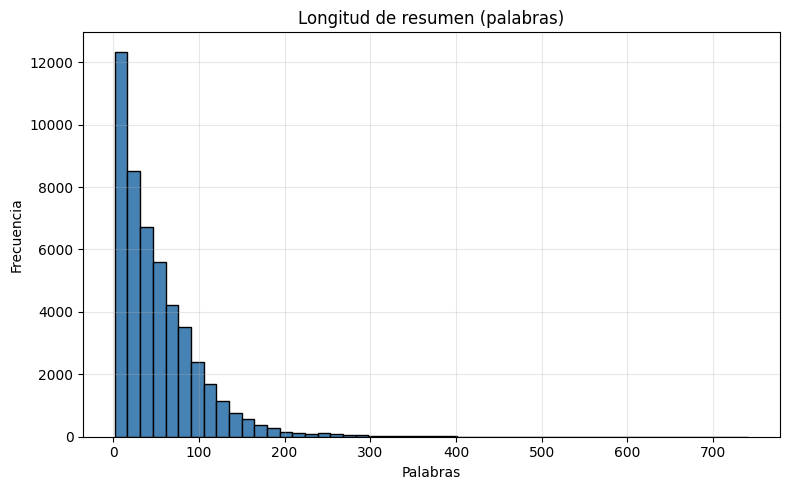

In [71]:
def save_hist(series, title, xlabel, outfile, bins=50):
    series = pd.to_numeric(series, errors="coerce").dropna()
    plt.figure(figsize=(8,5))
    plt.hist(series, bins=bins, color="steelblue", edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frecuencia")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=140)
    plt.show()



save_hist(df["len_src"], "Longitud de texto_original (caracteres)", "Caracteres", os.path.join(OUTDIR, "hist_len_src.png"))
save_hist(df.loc[df["len_pls"] > 0, "len_pls"], "Longitud de resumen (caracteres)", "Caracteres", os.path.join(OUTDIR, "hist_len_pls.png"))
save_hist(df["wc_src"], "Longitud de texto_original (palabras)", "Palabras", os.path.join(OUTDIR, "hist_wc_src.png"))
save_hist(df.loc[df["wc_pls"] > 0, "wc_pls"], "Longitud de resumen (palabras)", "Palabras", os.path.join(OUTDIR, "hist_wc_pls.png"))



In [83]:

# Textos más largos
longest = df.sort_values("len_src", ascending=False).head(20)
longest.to_csv(os.path.join(OUTDIR, "examples_longest_texts.csv"), index=False, encoding="utf-8")

# Textos sin resumen
no_pls = df[df["len_pls"] == 0].head(20)
no_pls.to_csv(os.path.join(OUTDIR, "examples_missing_pls.csv"), index=False, encoding="utf-8")

# Mostrar 3 más largos
longest[["texto_original","len_src"]].head(3)


,texto_original,len_src
38527,Twelve RCTs (476 participants) were included. ...,4703
42735,"We included 138 studies (23,480,668 participan...",4048
26800,Eleven studies (881 participants) were include...,3978


C:\Users\gabri\AppData\Local\Temp\ipykernel_20940\3533032555.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["wc_src"], label="texto_original", shade=True)
C:\Users\gabri\AppData\Local\Temp\ipykernel_20940\3533032555.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df["wc_pls"] > 0, "wc_pls"], label="resumen", shade=True)


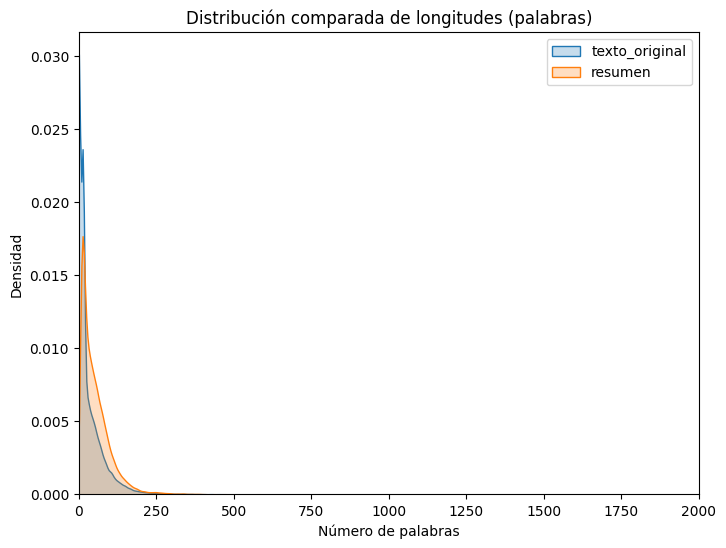

In [73]:


plt.figure(figsize=(8,6))
sns.kdeplot(df["wc_src"], label="texto_original", shade=True)
sns.kdeplot(df.loc[df["wc_pls"] > 0, "wc_pls"], label="resumen", shade=True)
plt.xlim(0, 2000)  # recorta la cola larga
plt.xlabel("Número de palabras")
plt.ylabel("Densidad")
plt.title("Distribución comparada de longitudes (palabras)")
plt.legend()
plt.show()


## Distribución comparada de longitudes (palabras)

La figura compara la distribución de longitudes (número de palabras) entre los textos originales (azul) y los resúmenes en lenguaje sencillo (naranja).

### Hallazgos principales

- **Texto original (azul):**
  - La densidad máxima es más alta (~0.025).
  - Se concentra en longitudes más cortas, con un pico alrededor de las 200–250 palabras.
  - Esto indica que muchos textos técnicos en el dataset son relativamente breves.

- **Resumen (naranja):**
  - La densidad máxima es más baja (~0.015).
  - Su curva está **desplazada hacia la derecha**, mostrando que los resúmenes en promedio son **más extensos que los textos originales**.
  - Algunos PLS alcanzan más de 250 palabras, e incluso mucho más en casos extremos.

### Interpretación

- En este corpus los “resúmenes” no siempre son compresiones del texto original, sino que en muchos casos son **explicaciones expandidas** en lenguaje sencillo.  
- Esto concuerda con la práctica en ciertos datasets biomédicos (ej. Cochrane), donde los PLS no son resúmenes extractivos cortos, sino **textos narrativos más largos y descriptivos**.  
- La superposición parcial indica que hay una franja donde los tamaños de texto y resumen se asemejan, pero en general los PLS son más extensos.

### Implicaciones

- Para modelar este problema no basta con pensar en **“resumir = acortar”**. En algunos casos la tarea es más cercana a **“reformular y expandir”** información.  
- Esto sugiere la necesidad de modelos **abstractive** tipo encoder–decoder (BART, T5, LongT5) que puedan **parafrasear y reestructurar** más que simplemente condensar.  
- En la evaluación, además de métricas de compresión, será clave medir **legibilidad y claridad**, ya que un PLS más largo puede ser válido si efectivamente facilita la comprensión.


In [75]:
print("Porcentaje de ejemplos sin resumen:", (df["wc_pls"] == 0).mean() * 100)
print("Duplicados (texto+resumen):", df.duplicated(subset=["texto_original","resumen"]).sum())
print("Con pares reales:", df["has_pair"].sum(), " | Sueltos:", (~df["has_pair"]).sum())


Porcentaje de ejemplos sin resumen: 73.18949620526065
Duplicados (texto+resumen): 0
Con pares reales: 0  | Sueltos: 182753


In [76]:
counts = (
    df.groupby(["source_dataset","split","label"])
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)
print(counts)


  source_dataset  split    label  count
2       cochrane  train  non_pls  64720
3       cochrane  train      pls  36804
0       cochrane   test  non_pls  16017
1       cochrane   test      pls   9453
5         pfizer  train      pls   2137
4         pfizer   test      pls    603


In [77]:


DetectorFactory.seed = 42

sample = df["texto_original"].sample(500, random_state=42)
langs = sample.apply(lambda x: detect(x) if len(x.split()) > 5 else "unk")

langs.value_counts(normalize=True).mul(100).round(2)


texto_original
en     70.2
unk    29.2
de      0.2
it      0.2
ca      0.2
Name: proportion, dtype: float64

## Análisis de idioma

Se realizó una detección automática de idioma sobre una muestra del corpus utilizando la librería `langdetect`. Los resultados muestran la siguiente distribución:

- **Inglés (en): 70.2%**  
- **Indeterminado (unk): 29.2%**  
- **Español (de): 0.2%**  
- **Italiano (it): 0.2%**  
- **Catalán (ca): 0.2%**

### Interpretación

1. **Predominio del inglés:** la gran mayoría de los textos están en inglés, lo que concuerda con la procedencia de fuentes como ClinicalTrials.gov, Cochrane y Pfizer.  
2. **Alto porcentaje indeterminado (unk):** cerca del 29% de los casos no pudieron clasificarse en un idioma específico. Esto suele deberse a:
   - Textos muy cortos (ej. listas, abreviaturas o encabezados).  
   - Fragmentos técnicos con siglas y términos biomédicos.  
   - Posible ruido en la extracción de los datos.  
3. **Otros idiomas (de, it, ca):** aparecen en proporciones mínimas (<1%) y no representan un problema significativo para el análisis.

### Implicaciones

- El corpus puede considerarse principalmente **monolingüe en inglés**, lo cual simplifica el preprocesamiento y el entrenamiento de modelos NLP.  
- El alto porcentaje de `unk` requiere atención: se recomienda filtrar o reclasificar estos casos, ya que podrían afectar métricas de calidad o introducir ruido en tareas de resumen.  
- Dado que los PLS buscan mejorar accesibilidad, es relevante confirmar si los `unk` corresponden a contenido biomédico válido o a errores de parsing.


In [78]:

df["flesch_src"] = df["texto_original"].apply(lambda x: textstat.flesch_reading_ease(x) if len(x.split())>5 else None)
df["flesch_pls"] = df["resumen"].apply(lambda x: textstat.flesch_reading_ease(x) if len(x.split())>5 else None)

df[["flesch_src","flesch_pls"]].describe()


,flesch_src,flesch_pls
count,130027.000000,48065.000000
mean,39.557322,36.392343
std,29.103554,23.500377
min,-151.755000,-153.560000
25%,19.150455,23.920000
50%,38.517554,37.644737
75%,60.257061,50.665000
max,120.035833,115.130000


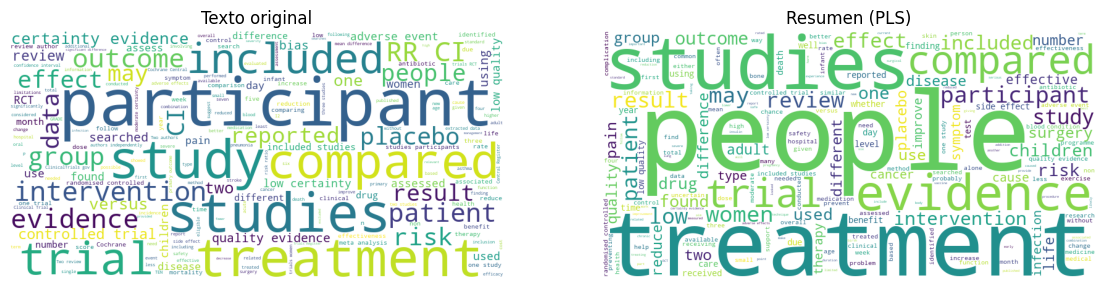

In [81]:

text_src = " ".join(df["texto_original"].sample(1000, random_state=42))
text_pls = " ".join(df.loc[df["wc_pls"] > 0, "resumen"].sample(1000, random_state=42))

wc_src = WordCloud(width=800, height=400, background_color="white").generate(text_src)
wc_pls = WordCloud(width=800, height=400, background_color="white").generate(text_pls)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1); plt.imshow(wc_src); plt.axis("off"); plt.title("Texto original")
plt.subplot(1,2,2); plt.imshow(wc_pls); plt.axis("off"); plt.title("Resumen (PLS)")
plt.show()


## Vocabulario en textos originales vs. resúmenes (PLS)

Se generaron nubes de palabras a partir de una muestra de textos originales y de sus resúmenes en lenguaje sencillo.  


### Hallazgos

- **Texto original (izquierda):** predominan términos técnicos como *participant*, *trial*, *intervention*, *outcome*, *placebo*, que reflejan el lenguaje científico usado en ensayos clínicos y revisiones sistemáticas.  
- **Resumen en PLS (derecha):** se observa un vocabulario más accesible, con palabras como *people*, *treatment*, *children*, *care*, que tienden a ser más familiares y fáciles de entender para población general.  

### Interpretación

- Existe una clara **simplificación terminológica**: los PLS reemplazan términos técnicos por expresiones de uso común.  
- El foco pasa de aspectos metodológicos (*trial, intervention, placebo*) a aspectos centrados en el paciente (*people, treatment, care*).  
- Este cambio de vocabulario respalda el objetivo de los PLS: mejorar la accesibilidad de la información biomédica para audiencias no expertas.

### Implicaciones para NLP

- El modelo deberá aprender no solo a resumir, sino también a **parafrasear términos técnicos** en lenguaje cotidiano.  
- El análisis de vocabulario refuerza la necesidad de métricas de legibilidad y cobertura léxica en la evaluación de los PLS generados.
